## 단계변수 X

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import optuna

In [6]:
df = pd.read_csv('0916 착과수 최종.csv')

In [7]:
#train-test 분리
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X = df.iloc[:, 2:]
y = df.iloc[:, 1]

X_train = df.iloc[:split_index, 2:]  # 처음 80%의 행을 훈련 데이터로 사용 
y_train = df.iloc[:split_index, 1]   # 처음 80%의 행을 훈련 데이터의 타겟 값으로 사용 
X_test = df.iloc[split_index:, 2:]   # 나머지 20%의 행을 테스트 데이터로 사용 
y_test = df.iloc[split_index:, 1] # 나머지 20%의 행을 테스트 데이터로 사용

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20851, 7) (5213, 7) (20851,) (5213,)


In [8]:
#정규화 진행
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test = scaler_y.transform(y_test.values.reshape(-1,1))

In [9]:
X_train_df = pd.DataFrame(X_train, columns=['PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1','HTNG_TPRT_1', 'SPL_TPRT_2', 'AVE_INNER_HMDT_1_2','SKLT_OPDR_RATE_1_RIGHT', 'GDD'])
y_train_df = pd.DataFrame(y_train, columns=['FRST_TREE_CNT'])
df_train = pd.concat([y_train_df, X_train_df], axis=1)

#날짜열 추가 및 순서 앞으로 옮기기
df_train['STRG_DT'] = df['STRG_DT']
df_train = df_train[['STRG_DT'] + [col for col in df_train if col != 'STRG_DT']]

In [10]:
df_train

,STRG_DT,FRST_TREE_CNT,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
0,2022-01-01 0:00,-0.102251,-0.043934,0.858048,-0.293285,-3.266703,0.190960,-0.672832,-0.075804
1,2022-01-01 0:10,-0.102251,-0.010636,1.737274,-0.293285,-3.220612,0.190960,-0.672832,-0.075804
2,2022-01-01 0:20,-0.102251,0.089257,1.417556,-0.293285,-3.189884,0.065110,-0.672832,-0.075804
3,2022-01-01 0:30,-0.102251,0.067058,1.257696,-0.293285,-3.205248,0.149010,-0.672832,-0.075804
4,2022-01-01 0:40,-0.102251,0.078158,1.231053,-0.293285,-3.251339,0.407701,-0.672832,-0.075804
...,...,...,...,...,...,...,...,...,...
20846,2022-05-25 18:20,-2.201073,-0.709887,1.191088,-1.859606,0.128691,-2.374974,0.232825,0.122240
20847,2022-05-25 18:30,-2.201073,-0.665490,1.151124,-1.859606,0.205510,-2.367983,0.232825,0.122240
20848,2022-05-25 18:40,-2.201073,-0.654391,1.124480,-1.859606,0.190146,-2.353999,0.232825,0.122240
20849,2022-05-25 18:50,-2.201073,-0.698788,1.057872,-1.859606,0.159418,-2.270100,0.232825,0.122240


### 1) optuna 사용해서 하이퍼파라미터 튜닝

In [37]:
# Objective 함수 정의 (하이퍼파라미터 최적화)
def objective(trial):
    X_train = df_train.iloc[:, 2:]  # 처음 80%의 행을 훈련 데이터로 사용 
    y_train = df_train.iloc[:, 1]   # 처음 80%의 행을 훈련 데이터의 타겟 값으로 사용 
    
    n_splines = trial.suggest_int("n_splines", 5, 10)
    lam = trial.suggest_float("lam", 1e-5, 10, log=True)
    
    # K-폴드 교차 검증을 위한 루프
    mse_scores = []
    kf = KFold(n_splits=10, shuffle=False)  # 10개 폴드를 사용하도록 설정 (shuffle=True로 설정)
    
    for train_idx, valid_idx in kf.split(X_train):  # 정수 인덱스를 선택
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
        # LinearGAM 모델 초기화
        gam = LinearGAM(n_splines=n_splines, lam=lam)
    
        # 모델을 훈련 데이터에 적합
        gam.fit(X_train_fold, y_train_fold)
    
        # 모델로 예측
        y_pred = gam.predict(X_valid_fold)
    
        # 검증 세트에서 평가 (예: 평균 제곱 오차를 최소화하려고 함)
        mse = mean_squared_error(y_valid_fold, y_pred)
        mse_scores.append(mse)
    
    # K-폴드 검증 결과의 평균을 반환
    return np.mean(mse_scores)

# Study 객체 생성 및 최적화 실행
study = optuna.create_study(direction="minimize")  # 목표는 MSE를 최소화
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 얻기
best_params = study.best_params

# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", best_params)

[I 2023-09-24 19:39:25,481] A new study created in memory with name: no-name-67cd70ab-ce31-4537-9281-7d4d7429e03c
[I 2023-09-24 19:39:32,415] Trial 0 finished with value: 1.1458853057174856 and parameters: {'n_splines': 8, 'lam': 0.15142716052469968}. Best is trial 0 with value: 1.1458853057174856.
[I 2023-09-24 19:39:39,129] Trial 1 finished with value: 1.1320852004200832 and parameters: {'n_splines': 8, 'lam': 2.393809089164693e-05}. Best is trial 1 with value: 1.1320852004200832.
[I 2023-09-24 19:39:43,736] Trial 2 finished with value: 1.2623934441575912 and parameters: {'n_splines': 5, 'lam': 0.006589224853644911}. Best is trial 1 with value: 1.1320852004200832.
[I 2023-09-24 19:39:51,834] Trial 3 finished with value: 1.158887039684485 and parameters: {'n_splines': 9, 'lam': 0.38655139281263706}. Best is trial 1 with value: 1.1320852004200832.
[I 2023-09-24 19:39:59,988] Trial 4 finished with value: 1.156706312818907 and parameters: {'n_splines': 9, 'lam': 0.5231518658089535}. Best

[I 2023-09-24 19:45:00,441] Trial 43 finished with value: 1.1296396281695955 and parameters: {'n_splines': 8, 'lam': 0.004313809737690731}. Best is trial 43 with value: 1.1296396281695955.
[I 2023-09-24 19:45:12,322] Trial 44 finished with value: 1.1826202340697245 and parameters: {'n_splines': 7, 'lam': 0.014723088901708523}. Best is trial 43 with value: 1.1296396281695955.
[I 2023-09-24 19:45:25,484] Trial 45 finished with value: 1.129539287777708 and parameters: {'n_splines': 8, 'lam': 0.005044988797665881}. Best is trial 45 with value: 1.129539287777708.
[I 2023-09-24 19:45:37,355] Trial 46 finished with value: 1.185340503893627 and parameters: {'n_splines': 7, 'lam': 0.0070290975612286805}. Best is trial 45 with value: 1.129539287777708.
[I 2023-09-24 19:45:51,362] Trial 47 finished with value: 1.2648982208539639 and parameters: {'n_splines': 9, 'lam': 0.014444337927613595}. Best is trial 45 with value: 1.129539287777708.
[I 2023-09-24 19:46:03,598] Trial 48 finished with value: 1

최적 하이퍼파라미터: {'n_splines': 8, 'lam': 0.005044988797665881}


In [67]:
#optuna로 선택한 하이퍼파라미터 사용한 모델
gam_1 = LinearGAM(n_splines = 8, lam = 0.005044988797665881).fit(X_train, y_train)
gam_1.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.7827
Link Function:                     IdentityLink Log Likelihood:                                -26433.0958
Number of Samples:                        20851 AIC:                                             52965.757
                                                AICc:                                           52966.0001
                                                GCV:                                                0.3773
                                                Scale:                                              0.3757
                                                Pseudo R-Squared:                                   0.6252
Feature Function                  Lam

C:\Users\80700\AppData\Local\Temp/ipykernel_15760/1370879620.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_1.summary()


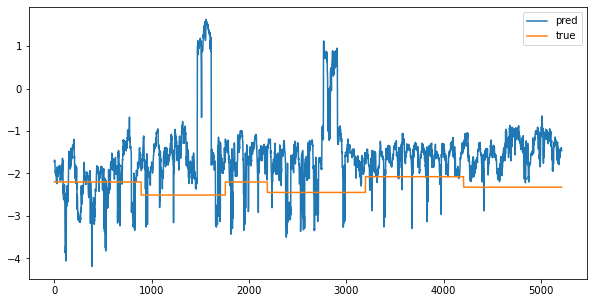

In [77]:
y_pred = gam_1.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(np.array(y_pred),label = "pred")
plt.plot(np.array(y_test),label = "true")
plt.legend()
plt.show()

In [69]:
# 정규화된 데이터를 역으로 변환
scaler = StandardScaler()
scaled_data = df1.iloc[:split_index, 1].values.reshape(-1, 1)  # 1D 데이터를 2D로 변환
scaler.fit(scaled_data)

# 이미 정규화된 y_pred 값을 역으로 변환
y_pred_origin = scaler.inverse_transform(y_pred)
y_test_origin = scaler.inverse_transform(y_test)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test_origin, y_pred_origin))

print("RMSE:", rmse)

RMSE: 2.189854756659158


- Distribution (분포): 모델의 종속 변수가 정규 분포(Normal Distribution)를 따른다고 가정합니다.

- Link Function (링크 함수): 모델의 링크 함수는 Identity Link입니다. 이는 종속 변수와 예측 값 사이에 직접적인 선형 관계를 나타냄.

- Effective Degrees of Freedom (EDoF): 모델의 유효 자유도. 이 값은 모델의 유연성을 나타내며, 너무 크면 과적합 위험. 적당해야함

- Log Likelihood (로그 우도): 모델이 관찰된 데이터를 얼마나 잘 설명하는지를 나타냄. 값이 높을수록 모델이 데이터를 잘 설명.

- AIC (Akaike Information Criterion): AIC 값은 . 값이 낮을수록 모델이 더 좋음.

- AICc (AIC 보정): AIC의 보정된 버전.

- GCV (Generalized Cross-Validation): GCV 값은 모델의 일반화 성능을 평가하는 지표. 값이 낮을수록 모델이 더 좋음.

- Scale (스케일): 종속 변수의 스케일.

- Pseudo R-Squared (의사 결정 계수): 모델의 의사 결정 계수, 모델이 종속 변수의 분산을 얼마나 설명하는지를 나타내는 지표. 값이 1에 가까울수록 모델이 데이터를 잘 설명.

- n_splines : 숫자가 커질수록 더 유연, 3보다 크도록 설정해야함

's(0)', 's(1)', 's(2)' 등의 특성은 각각의 스무딩 함수를 나타내며, Lambda 값은 해당 스무딩 함수의 유연성을 조절하는데 사용되는 파라미터로, 값이 작을수록 유연해짐. 대신 과적합 위험 증가. P-값은 해당 스무딩 함수가 통계적으로 유의미한지를 나타내며, 유의성 코드가 '***'로 표시된 특성은 매우 유의미하며, P-값이 작을수록 해당 특성이 모델에 중요하게 기여한다는 것을 나타냄.



### gridsearch 사용

In [42]:
for i in range(4, 11): #n_spline 4~10
    gam = LinearGAM(n_splines = i).fit(X_train, y_train)
    gam.gridsearch(X_train, y_train)
    s = gam.summary()
    print(s)
    globals()[f'gam_{i-2}'] = gam


100% (11 of 11) |########################| Elapsed Time: 0:00:09 Time:  0:00:09
C:\Users\80700\AppData\Local\Temp/ipykernel_15760/534739858.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  s = gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.8457
Link Function:                     IdentityLink Log Likelihood:                                -25637.9674
Number of Samples:                        20851 AIC:                                            51321.6262
                                                AICc:                                           51321.6785
                                                GCV:                                                0.4543
                                                Scale:                                              0.4534
                                                Pseudo R-Squared:                                   0.5471
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
C:\Users\80700\AppData\Local\Temp/ipykernel_15760/534739858.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  s = gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     28.8998
Link Function:                     IdentityLink Log Likelihood:                                -25780.1357
Number of Samples:                        20851 AIC:                                             51620.071
                                                AICc:                                           51620.1598
                                                GCV:                                                0.4304
                                                Scale:                                              0.4293
                                                Pseudo R-Squared:                                   0.5713
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:13 Time:  0:00:13
C:\Users\80700\AppData\Local\Temp/ipykernel_15760/534739858.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  s = gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      35.816
Link Function:                     IdentityLink Log Likelihood:                                -26120.9607
Number of Samples:                        20851 AIC:                                            52315.5533
                                                AICc:                                           52315.6871
                                                GCV:                                                0.3977
                                                Scale:                                              0.3965
                                                Pseudo R-Squared:                                   0.6042
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:17 Time:  0:00:17
C:\Users\80700\AppData\Local\Temp/ipykernel_15760/534739858.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  s = gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     42.2077
Link Function:                     IdentityLink Log Likelihood:                                -26241.2397
Number of Samples:                        20851 AIC:                                            52568.8949
                                                AICc:                                           52569.0786
                                                GCV:                                                 0.389
                                                Scale:                                              0.3876
                                                Pseudo R-Squared:                                   0.6132
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:16 Time:  0:00:16
C:\Users\80700\AppData\Local\Temp/ipykernel_15760/534739858.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  s = gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.6844
Link Function:                     IdentityLink Log Likelihood:                                -26434.1151
Number of Samples:                        20851 AIC:                                             52965.599
                                                AICc:                                           52965.8316
                                                GCV:                                                0.3773
                                                Scale:                                              0.3757
                                                Pseudo R-Squared:                                   0.6251
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:19 Time:  0:00:19
C:\Users\80700\AppData\Local\Temp/ipykernel_15760/534739858.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  s = gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     55.7197
Link Function:                     IdentityLink Log Likelihood:                                 -26578.389
Number of Samples:                        20851 AIC:                                            53270.2174
                                                AICc:                                           53270.5323
                                                GCV:                                                0.3694
                                                Scale:                                              0.3676
                                                Pseudo R-Squared:                                   0.6333
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     63.3891
Link Function:                     IdentityLink Log Likelihood:                                -26589.3454
Number of Samples:                        20851 AIC:                                            53307.4691
                                                AICc:                                           53307.8742
                                                GCV:                                                0.3686
                                                Scale:                                              0.3666
                                                Pseudo R-Squared:                                   0.6345
Feature Function                  Lam

C:\Users\80700\AppData\Local\Temp/ipykernel_15760/534739858.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  s = gam.summary()


GCV가 n_splines = 5일때 가장 낮아서 선택, n_splines = 5일때 최적의 lam값

In [54]:
gam_3.summary()
gam_3.lam

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     28.8998
Link Function:                     IdentityLink Log Likelihood:                                -25780.1357
Number of Samples:                        20851 AIC:                                             51620.071
                                                AICc:                                           51620.1598
                                                GCV:                                                0.4304
                                                Scale:                                              0.4293
                                                Pseudo R-Squared:                                   0.5713
Feature Function                  Lam

C:\Users\80700\AppData\Local\Temp/ipykernel_15760/3403107765.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_3.summary()


[[0.001], [0.001], [0.001], [0.001], [0.001], [0.001], [0.001]]

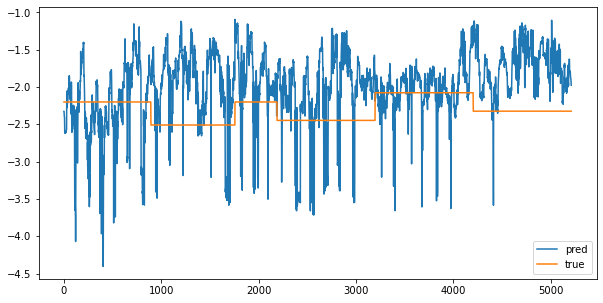

In [71]:
y_pred = gam_3.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(np.array(y_pred),label = "pred")
plt.plot(np.array(y_test),label = "true")
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))


In [72]:
# 정규화된 데이터를 역으로 변환합니다.
scaler = StandardScaler()
scaled_data = df1.iloc[:split_index, 1].values.reshape(-1, 1)  # 1D 데이터를 2D로 변환
scaler.fit(scaled_data)

# 이미 정규화된 y_pred 값을 역으로 변환합니다.
y_pred_origin = scaler.inverse_transform(y_pred)
y_test_origin = scaler.inverse_transform(y_test)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test_origin, y_pred_origin))

print("RMSE:", rmse)

RMSE: 1.2021278312786594


### Partial Dependence Plot (독립변수의 종속변수 영향력을 나타냄)

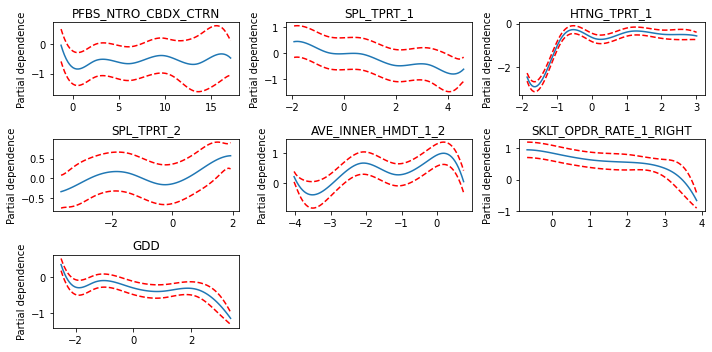

In [70]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(10, 5))  # 3행 3열의 서브플롯 생성

# 각 서브플롯에 원하는 타이틀 설정
feature_names = ['PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1', 'HTNG_TPRT_1', 'SPL_TPRT_2', 
                 'AVE_INNER_HMDT_1_2', 'SKLT_OPDR_RATE_1_RIGHT', 'GDD']

for i, ax in enumerate(axs.ravel()):
    if i < len(feature_names):  # 마지막 행의 2번째와 3번째 열은 제외
        XX = gam_1.generate_X_grid(term=i)
        ax.plot(XX[:, i], gam_1.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], gam_1.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        ax.set_ylabel('Partial dependence')
        ax.set_title(f'{feature_names[i]}')  # 원하는 타이틀로 설정
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


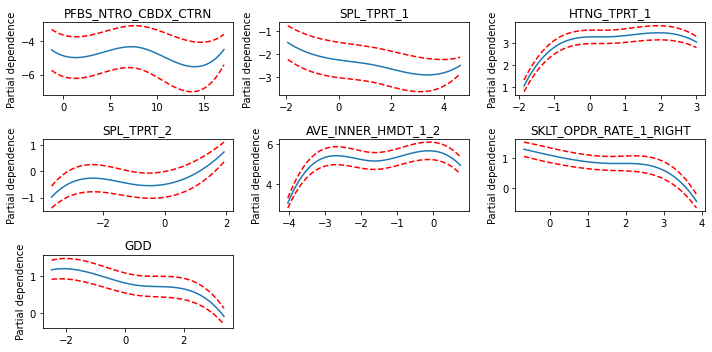

In [60]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(10, 5))  # 3행 3열의 서브플롯 생성

# 각 서브플롯에 원하는 타이틀 설정
feature_names = ['PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1', 'HTNG_TPRT_1', 'SPL_TPRT_2', 
                 'AVE_INNER_HMDT_1_2', 'SKLT_OPDR_RATE_1_RIGHT', 'GDD']

for i, ax in enumerate(axs.ravel()):
    if i < len(feature_names):  # 마지막 행의 2번째와 3번째 열은 제외
        XX = gam_3.generate_X_grid(term=i)
        ax.plot(XX[:, i], gam_3.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], gam_3.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        ax.set_ylabel('Partial dependence')
        ax.set_title(f'{feature_names[i]}')  # 원하는 타이틀로 설정
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [62]:
# optuna, gridsearch 비교를 위한 K-폴드 교차 검증을 위한 루프

kf = KFold(n_splits=10, shuffle=False)  # 10개 폴드를 사용하도록 설정 (shuffle=True로 설정)
mse_list = []

for i in range(1, 9):
    mse_scores = []
    for train_idx, valid_idx in kf.split(X_train):  # 정수 인덱스를 선택
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        lam_value = getattr(globals()[f'gam_{i}'], 'lam', [])[0][0]
        n_splines_value = getattr(globals()[f'gam_{i}'], 'n_splines', [])[0]
        
        # LinearGAM 모델 초기화
        gam = LinearGAM(n_splines = n_splines_value, lam = lam_value)
    
        # 모델을 훈련 데이터에 적합
        gam.fit(X_train_fold, y_train_fold)
    
        # 모델로 예측
        y_pred = gam.predict(X_valid_fold)
    
        # 검증 세트에서 평가 (예: 평균 제곱 오차를 최소화하려고 함)
        mse = mean_squared_error(y_valid_fold, y_pred)
        mse_scores.append(mse)
        
    mse_list.append(np.mean(mse_scores))
    
print(mse_list)

[1.129539287777708, 1.380906719905361, 1.2557521798524154, 1.2299816813673803, 1.186693338102232, 1.129580452808644, 1.285897232207033, 1.5456632491040359]


### 예측값을 일별로 평균내서 groupby 후, rmse, r^2 계산 and dataframe 반환

In [83]:
def daily_mean(y_pred, y_test):
    #예측값과 test 값을 일별로 평균내기
    df = pd.read_csv('0916 착과수 최종.csv')
    new_df = pd.DataFrame()
    
    split_ratio = 0.8
    split_index = int(len(df) * split_ratio)

    new_df['STRG_DT'] = df.iloc[split_index:, :]['STRG_DT']
    new_df['y_test'] = y_test
    new_df['y_pred'] = y_pred

    new_df['STRG_DT'] = pd.to_datetime(new_df['STRG_DT'])


    # 'STRG_DT' 열을 인덱스로 설정
    new_df.set_index('STRG_DT', inplace=True)

    # 날짜별로 그룹화하고 평균을 계산
    daily_mean = new_df.groupby(new_df.index.date).mean()


    #역정규화
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    scaled_data = df.iloc[:split_index, 1].values.reshape(-1, 1)  # 1D 데이터를 2D로 변환
    scaler.fit(scaled_data)

    # 이미 정규화된 y_pred 값을 역으로 변환합니다.
    daily_mean['y_pred'] = scaler.inverse_transform(daily_mean['y_pred'])
    daily_mean['y_test'] = scaler.inverse_transform(daily_mean['y_test'])

    #오차 계산
    daily_mean['error'] = daily_mean['y_test'] - daily_mean['y_pred']

    #그래프 계산
    plt.figure(figsize=(10,5))
    plt.plot(np.array(daily_mean['y_pred']),label = "pred")
    plt.plot(np.array(daily_mean['y_test']),label = "true")
    plt.legend()
    plt.show()


    #score 계산
    from sklearn.metrics import mean_squared_error, r2_score

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(daily_mean['y_test'], daily_mean['y_pred']))

    # R^2 계산
    r_squared = r2_score(daily_mean['y_test'], daily_mean['y_pred'])

    # RMSE와 R^2 값을 리스트로 반환
    score = [rmse, r_squared]
    
    return daily_mean, score

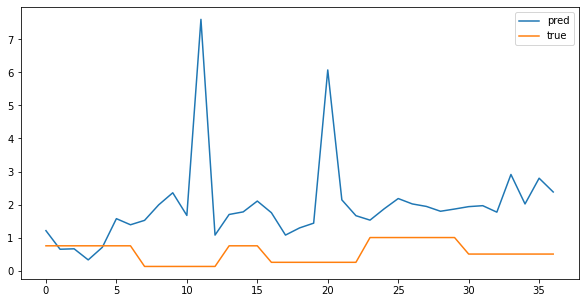

In [84]:
daily_mean, score = daily_mean(y_pred, y_test)

In [85]:
daily_mean

,y_test,y_pred,error
2022-05-25,0.750,1.208910,-0.458910
2022-05-26,0.750,0.646087,0.103913
2022-05-27,0.750,0.659128,0.090872
2022-05-28,0.750,0.323523,0.426477
2022-05-29,0.750,0.703978,0.046022
2022-05-30,0.750,1.572086,-0.822086
2022-05-31,0.750,1.387226,-0.637226
2022-06-01,0.125,1.520970,-1.395970
2022-06-02,0.125,1.989708,-1.864708
2022-06-03,0.125,2.355857,-2.230857


In [86]:
score

[2.0026424332276296, -40.82226725700094]